In [1]:
!pip install pandas==1.3.4
!pip install transformers==4.12.5
!pip install datasets==1.15.1
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 11.5 MB 11.9 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 3.1 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 33.3 MB/s eta 0:00:01
     |████████████████████████████████| 101 kB 38.3 MB/s ta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 290 kB 21.7 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 45.8 MB/s eta 0:00:01
     |████████████████████████████████| 35.3 MB 20.2 MB/s eta 0:00:01
     |████████████████████████████████| 212 kB 33.1 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 141 kB 39.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 19.2 MB/s eta 0:00:01
     |█████████████████

In [2]:
import os
import pickle

from collections import Counter

# import pandas as pd
from sklearn.metrics import classification_report

import numpy as np
import torch
import torch.nn as nn

import transformers
from transformers import Trainer
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers.data.data_collator import DataCollatorWithPadding

import datasets
from datasets import Dataset
from datasets import ClassLabel
from datasets import load_metric

## Global variables

In [3]:
DATA_FOLDER = '/notebooks/Data/bert_sequence_classification'
DATA_FILE = '/notebooks/linguistic_features/data/hf_datasets/pe_dataset_w_essay_position_pos_tags.pt'
RESULTS_FOLDER = '/notebooks/Results/bert_sequence_classification'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

## Load data

In [6]:
dataset = torch.load(DATA_FILE)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['essay_nr', 'component_id', 'label_and_comp_idxs', 'text', 'label_x', 'label_ComponentType', 'relation_SupportAttack', 'label_RelationType', 'label_LinkedNotLinked', 'split', 'essay', 'argument_bound_1', 'argument_bound_2', 'argument_id', 'sentence', 'paragraph', 'para_nr', 'total_paras', 'token_count', 'token_count_covering_para', 'tokens_count_covering_sentence', 'preceeding_tokens_in_sentence_count', 'succeeding_tokens_in_sentence_count', 'token_ratio', 'relative_position_in_para_char', 'is_in_intro', 'relative_position_in_para_token', 'is_in_conclusion', 'is_first_in_para', 'is_last_in_para', 'nr_preceeding_comps_in_para', 'nr_following_comps_in_para', 'structural_fts_as_text', 'structural_fts_as_text_combined', 'para_ratio', 'first_or_last', 'strct_fts_w_position_in_essay', 'component_pos_tags', 'strct_fts_essay_position_pos_tags'],
        num_rows: 3770
    })
    test: Dataset({
        features: ['essay_nr', 'component_id',

In [8]:
dataset['train']['strct_fts_essay_position_pos_tags'][0]

'Topic: Gender Equality at university admission, Sentence: Therefore, universities follow the requirement of job providers and decide subject suitable for particular gender., First or last in essay: No, First in paragraph: No, Last in paragraph: Yes, In in introduction: No, Is in conclusion: No. Part Of Speech tags: NOUN, VERB, DET, NOUN, ADP, NOUN, NOUN, CCONJ, VERB, NOUN, ADJ, ADP, ADJ, NOUN'

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
label_names = set(dataset['train']['label_ComponentType'])
label_nb = len(label_names)
labels = ClassLabel(num_classes=label_nb, names=label_names)

In [11]:
labels

ClassLabel(num_classes=3, names={'Claim', 'MajorClaim', 'Premise'}, names_file=None, id=None)

In [12]:
def tokenize(batch):
    tokens = tokenizer(batch['strct_fts_essay_position_pos_tags'], truncation=True, padding=True, max_length=512)
    tokens['labels'] = labels.str2int(batch['label_ComponentType'])
    return tokens

In [13]:
dataset = dataset.map(tokenize, batched=True)

Parameter 'function'=<function tokenize at 0x7f6aa85b5310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['argument_bound_1', 'argument_bound_2', 'argument_id', 'attention_mask', 'component_id', 'component_pos_tags', 'essay', 'essay_nr', 'first_or_last', 'input_ids', 'is_first_in_para', 'is_in_conclusion', 'is_in_intro', 'is_last_in_para', 'label_ComponentType', 'label_LinkedNotLinked', 'label_RelationType', 'label_and_comp_idxs', 'label_x', 'labels', 'nr_following_comps_in_para', 'nr_preceeding_comps_in_para', 'para_nr', 'para_ratio', 'paragraph', 'preceeding_tokens_in_sentence_count', 'relation_SupportAttack', 'relative_position_in_para_char', 'relative_position_in_para_token', 'sentence', 'split', 'strct_fts_essay_position_pos_tags', 'strct_fts_w_position_in_essay', 'structural_fts_as_text', 'structural_fts_as_text_combined', 'succeeding_tokens_in_sentence_count', 'text', 'token_count', 'token_count_covering_para', 'token_ratio', 'token_type_ids', 'tokens_count_covering_sentence', 'total_paras'],
        num_rows: 3770
    })
    tes

In [16]:
train_dataset = dataset['train']#.shuffle(seed=42)
test_dataset = dataset['test']#.shuffle(seed=42)

# train_val_datasets = dataset['train'].train_test_split(train_size=0.8, seed=42)
# train_dataset = train_val_datasets['train']
val_dataset = dataset['validation']

In [17]:
dataset_d = {}
dataset_d['train'] = train_dataset
dataset_d['test'] = test_dataset
dataset_d['val'] = val_dataset

In [18]:
tokenizer.decode(dataset['train'][2945]['input_ids'])

'[CLS] topic : zoos have no useful purpose?, sentence : in the zoo you can see an animal and their different variations, the male and the female or the baby and the adult, first or last in essay : no, first in paragraph : no, last in paragraph : no, in in introduction : no, is in conclusion : no. part of speech tags : adp, det, noun, pron, verb, verb, det, noun, cconj, det, adj, noun, punct, det, noun, cconj, det, noun, cconj, det, noun, cconj, det, noun [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [19]:
# sanity check
set(dataset_d['train']['split'])

{'TRAIN'}

In [20]:
# sanity check
set(dataset_d['val']['split'])

{'TRAIN'}

In [21]:
# sanity check
set(dataset_d['test']['split'])

{'TEST'}

In [22]:
# global variables
NUM_LABELS = labels.num_classes
BATCH_SIZE = 48
NB_EPOCHS = 6

In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
class SoftMacroF1(nn.Module):
    
    def __init__(self):
        super(SoftMacroF1, self).__init__();

    def forward(self, predictions, targets):
        """
        Computes differentiable macro F1 score.

        Parameters
        ----------
        predictions : torch.Tensor
            tensor of predictions (float, 2D)

        targets : torch.Tensor
            tensor of targets (integers, 1D)

        Returns
        -------
        cost : torch.Tensor
            1 - differentiable macro F1 (0D, i.e., value)
        """
        dim = predictions.shape[1]
        soft_f1s = torch.zeros(size=(dim,))

        for i in range(dim):

            targets_tmp = targets == i

            targets_tmp = targets_tmp.float()
            # predictions_i = predictions[:, i].float()

            tp = torch.sum(predictions[:, i] * targets_tmp, axis=0)
            fp = torch.sum(predictions[:, i] * (1 - targets_tmp), axis=0)
            fn = torch.sum((1 - predictions[:, i]) * targets_tmp, axis=0)
            soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            soft_f1s[i] = soft_f1

        macro_f1 = torch.mean(soft_f1s, axis=0)

        cost = 1 - macro_f1 # reduce 1 - soft-f1 in order to increase soft-f1

        # macro_cost = tf.reduce_mean(cost) # average on all labels

        return cost

In [25]:
# https://huggingface.co/transformers/main_classes/trainer.html
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = SoftMacroF1() #nn.CrossEntropyLoss()#(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [26]:
metric = load_metric('f1')

def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return metric.compute(predictions=predictions, references=labels, average='macro')

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

In [27]:
training_args = TrainingArguments(
    
    # output
    output_dir=RESULTS_FOLDER,          
    
    # params
    num_train_epochs=NB_EPOCHS,               # nb of epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # cf. paper Sun et al.
    learning_rate=1e-5,#2e-5,                 # cf. paper Sun et al.
#     warmup_steps=500,                         # number of warmup steps for learning rate scheduler
    warmup_ratio=0.1,                         # cf. paper Sun et al.
    weight_decay=0.01,                        # strength of weight decay
    
    # eval
    evaluation_strategy="steps",              # cf. paper Sun et al.
    eval_steps=20,                            # cf. paper Sun et al.
    
    # log
    logging_dir="/notebooks/Results/bert_sequence_classification/tb_logs",  
    logging_strategy='steps',
    logging_steps=20,
    
    # save
    save_strategy='steps',
    save_total_limit=2,
    # save_steps=20, # default 500
    load_best_model_at_end=True,              # cf. paper Sun et al.
    # metric_for_best_model='eval_loss' 
    metric_for_best_model='f1'
)

In [28]:
trainer = CustomTrainer( # Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [29]:
results = trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_and_comp_idxs, argument_bound_2, strct_fts_essay_position_pos_tags, label_RelationType, nr_preceeding_comps_in_para, split, relation_SupportAttack, is_last_in_para, strct_fts_w_position_in_essay, para_ratio, is_in_conclusion, essay_nr, label_x, label_LinkedNotLinked, nr_following_comps_in_para, sentence, essay, relative_position_in_para_token, total_paras, label_ComponentType, token_count_covering_para, is_in_intro, component_id, tokens_count_covering_sentence, succeeding_tokens_in_sentence_count, text, structural_fts_as_text, para_nr, token_count, is_first_in_para, argument_bound_1, preceeding_tokens_in_sentence_count, argument_id, structural_fts_as_text_combined, component_pos_tags, first_or_last, relative_position_in_para_char, token_ratio, paragraph.
***** Running training *****
  Num examples = 3770
  Num Epochs = 6
  Instantaneous 

RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 7.80 GiB total capacity; 6.88 GiB already allocated; 18.31 MiB free; 6.93 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [29]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [30]:
test_trainer = Trainer(model, data_collator=DataCollatorWithPadding(tokenizer))
test_raw_preds, test_labels, _ = test_trainer.predict(test_dataset)
test_preds = np.argmax(test_raw_preds, axis=1)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_ComponentType, structural_fts_as_text, text, nr_preceeding_comps_in_para, token_ratio, component_id, tokens_count_covering_sentence, label_x, split, is_last_in_para, label_RelationType, component_pos_tags, essay_nr, succeeding_tokens_in_sentence_count, structural_fts_as_text_combined, first_or_last, nr_following_comps_in_para, is_in_conclusion, para_ratio, is_first_in_para, para_nr, relation_SupportAttack, label_and_comp_idxs, token_count, label_LinkedNotLinked, sentence, relative_position

In [31]:
len(test_preds)

1260

In [32]:
target_name = labels.int2str([0,1,2])
print(classification_report(test_labels, test_preds, target_names=target_name, digits=3))

              precision    recall  f1-score   support

       Claim      0.675     0.659     0.667       302
     Premise      0.921     0.886     0.903       805
  MajorClaim      0.764     0.954     0.849       153

    accuracy                          0.840      1260
   macro avg      0.787     0.833     0.806      1260
weighted avg      0.843     0.840     0.840      1260



In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

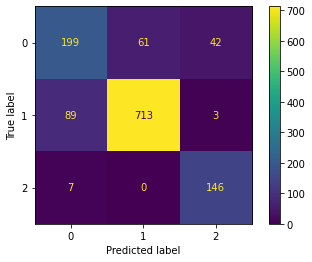

In [34]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_preds)